# Data Description

Data Set Information:

This dataset was derived from geospatial data from two sources: 
1) Landsat time-series satellite imagery from the years 2014-2015, and  
2) crowdsourced georeferenced polygons with land cover labels obtained from OpenStreetMap. 

The crowdsourced polygons cover only a small part of the image area, and are used used to extract training data from the image for classifying the rest of the image. The main challenge with the dataset is that both the imagery and the crowdsourced data contain noise (due to cloud cover in the images and innaccurate labeling/digitizing of polygons).

Files in zip folder
-The 'training.csv' file contains the training data for classification. Do not use this file to evaluate classification accuracy because it contains noise (many class labeling errors).
-The 'testing.csv' file contains testing data to evaluate the classification accuracy. This file does not contain any class labeling errors. 

Attribute Information:

class: The land cover class (impervious, farm, forest, grass, orchard, water) __[note: this is the target variable to classify]__.  

max_ndvi: the maximum NDVI (normalized difference vegetation index) value derived from the time-series of satellite images.
20150720_N - 20140101_N : NDVI values extracted from satellite images acquired between January 2014 and July 2015, in reverse chronological order (dates given in the format yyyymmdd).

[Data Source](https://archive.ics.uci.edu/ml/datasets/Crowdsourced+Mapping#)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import plot_confusion_matrix, accuracy_score, average_precision_score, classification_report

%matplotlib inline

# Import Data

In [49]:
train = pd.read_csv('training.csv')
test = pd.read_csv('testing.csv')
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       300 non-null    object 
 1   max_ndvi    300 non-null    float64
 2   20150720_N  300 non-null    float64
 3   20150602_N  300 non-null    float64
 4   20150517_N  300 non-null    float64
 5   20150501_N  300 non-null    float64
 6   20150415_N  300 non-null    float64
 7   20150330_N  300 non-null    float64
 8   20150314_N  300 non-null    float64
 9   20150226_N  300 non-null    float64
 10  20150210_N  300 non-null    float64
 11  20150125_N  300 non-null    float64
 12  20150109_N  300 non-null    float64
 13  20141117_N  300 non-null    float64
 14  20141101_N  300 non-null    float64
 15  20141016_N  300 non-null    float64
 16  20140930_N  300 non-null    float64
 17  20140813_N  300 non-null    float64
 18  20140626_N  300 non-null    float64
 19  20140610_N  300 non-null    f

## Get Insight

In [3]:
train.head(3)

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140610_N,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N
0,water,997.904,637.595,658.668,-1882.030,-1924.36,997.904,-1739.990,630.087,-1628.240,...,-921.193,-1043.160,-1942.490,267.138,366.608,452.238,211.328,-2203.02,-1180.190,433.906
1,water,914.198,634.240,593.705,-1625.790,-1672.32,914.198,-692.386,707.626,-1670.590,...,-954.719,-933.934,-625.385,120.059,364.858,476.972,220.878,-2250.00,-1360.560,524.075
2,water,3800.810,1671.340,1206.880,449.735,1071.21,546.371,1077.840,214.564,849.599,...,1562.210,1566.160,2208.440,1056.600,385.203,300.560,293.730,2762.57,150.931,3800.810


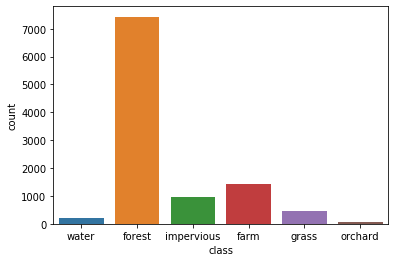

In [4]:
sns.countplot(train['class'])

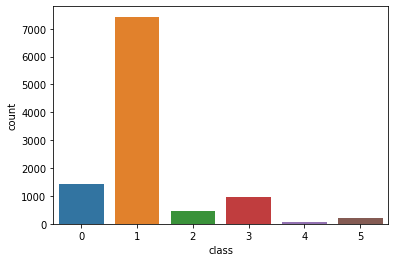

In [5]:
## Encoding class label to numeric
encoder = LabelEncoder()
classes = encoder.fit_transform(train['class'])
train['class'] = classes

sns.countplot(train['class'])

In [6]:
list(zip(encoder.classes_, sorted(train['class'].unique())))

[('farm', 0),
 ('forest', 1),
 ('grass', 2),
 ('impervious', 3),
 ('orchard', 4),
 ('water', 5)]

In [7]:
train.tail()

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140610_N,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N
10540,3,7579.58,6072.50,3803.14,3902.220,3897.43,3767.050,3985.77,4122.54,4240.230,...,7340.160,5513.73,1538.24,3507.360,1099.800,461.336,406.031,4652.03,2774.98,500.864
10541,3,2780.93,1895.68,1454.74,1265.480,1033.56,1930.380,1057.15,1471.60,1427.340,...,888.408,2093.02,1232.11,1190.830,1441.460,1170.880,1095.000,1818.65,2501.72,1247.770
10542,3,5833.76,3465.74,1283.32,413.412,4391.05,1146.820,4473.05,1614.75,770.469,...,5833.760,4047.32,4515.80,433.177,277.296,744.143,315.503,3759.71,3267.17,388.346
10543,3,3079.31,2435.30,1444.40,1133.760,1278.74,927.765,1917.04,1514.92,1685.130,...,1686.860,2050.94,1848.10,1725.820,1935.410,2089.710,668.160,1880.59,1614.84,1518.980
10544,3,7352.57,6941.19,1667.87,5084.780,4832.13,1588.950,5978.19,5462.33,3068.030,...,7352.570,3289.86,3729.15,1994.980,3556.040,5299.900,1562.760,5983.13,1249.71,2424.230


Text(0.5, 1.0, 'Data Distribution')

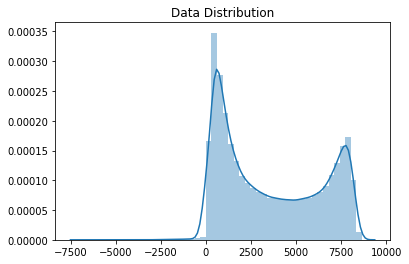

In [8]:
sns.distplot(train)
plt.title('Data Distribution')

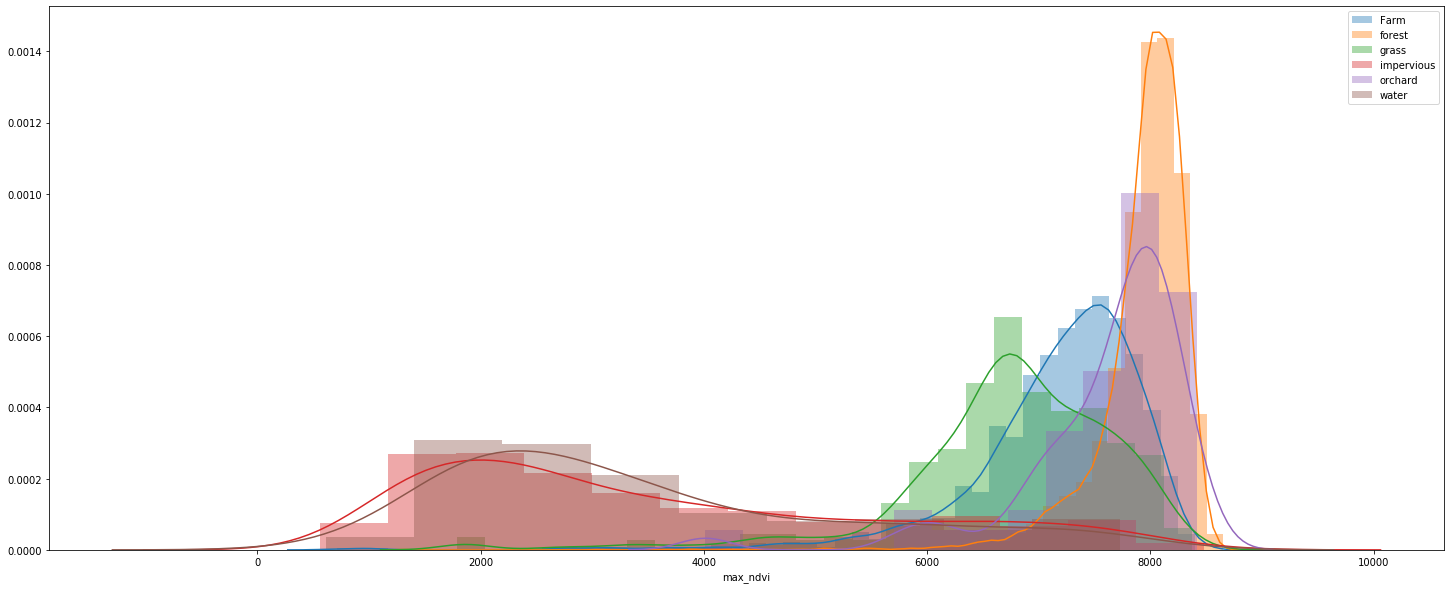

In [9]:
plt.figure(figsize=(25,10))
class_ndvi = train[train['class'] == 0]
sns.distplot(class_ndvi['max_ndvi'], label='Farm')
class_ndvi = train[train['class'] == 1]
sns.distplot(class_ndvi['max_ndvi'],  label='forest')
class_ndvi = train[train['class'] == 2]
sns.distplot(class_ndvi['max_ndvi'], label='grass')
class_ndvi = train[train['class'] == 3]
sns.distplot(class_ndvi['max_ndvi'], label='impervious')
class_ndvi = train[train['class'] == 4]
sns.distplot(class_ndvi['max_ndvi'], label='orchard')
class_ndvi = train[train['class'] == 5]
sns.distplot(class_ndvi['max_ndvi'], label='water')
plt.legend();

In [10]:
## adding mean and median column
median = train.iloc[:,2:].median(axis=1)
mean = train.iloc[:,2:].mean(axis=1)
train['median_NDVI'] = median
train['mean_NDVI'] = mean
train.head()

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N,median_NDVI,mean_NDVI
0,5,997.904,637.5950,658.668,-1882.030,-1924.36,997.904,-1739.990,630.087,-1628.240,...,-1942.490,267.138,366.608,452.238,211.328,-2203.02,-1180.190,433.906,211.328,-372.520370
1,5,914.198,634.2400,593.705,-1625.790,-1672.32,914.198,-692.386,707.626,-1670.590,...,-625.385,120.059,364.858,476.972,220.878,-2250.00,-1360.560,524.075,120.059,-278.627885
2,5,3800.810,1671.3400,1206.880,449.735,1071.21,546.371,1077.840,214.564,849.599,...,2208.440,1056.600,385.203,300.560,293.730,2762.57,150.931,3800.810,1071.210,1213.175111
3,5,952.178,58.0174,-1599.160,210.714,-1052.63,578.807,-1564.630,-858.390,729.790,...,-1786.950,-1227.800,304.621,291.336,369.214,-2202.12,600.359,-1343.550,210.714,-431.941726
4,5,1232.120,72.5180,-1220.880,380.436,-1256.93,515.805,-1413.180,-802.942,683.254,...,-1189.710,-924.073,432.150,282.833,298.320,-2197.36,626.379,-826.727,155.624,-324.122704


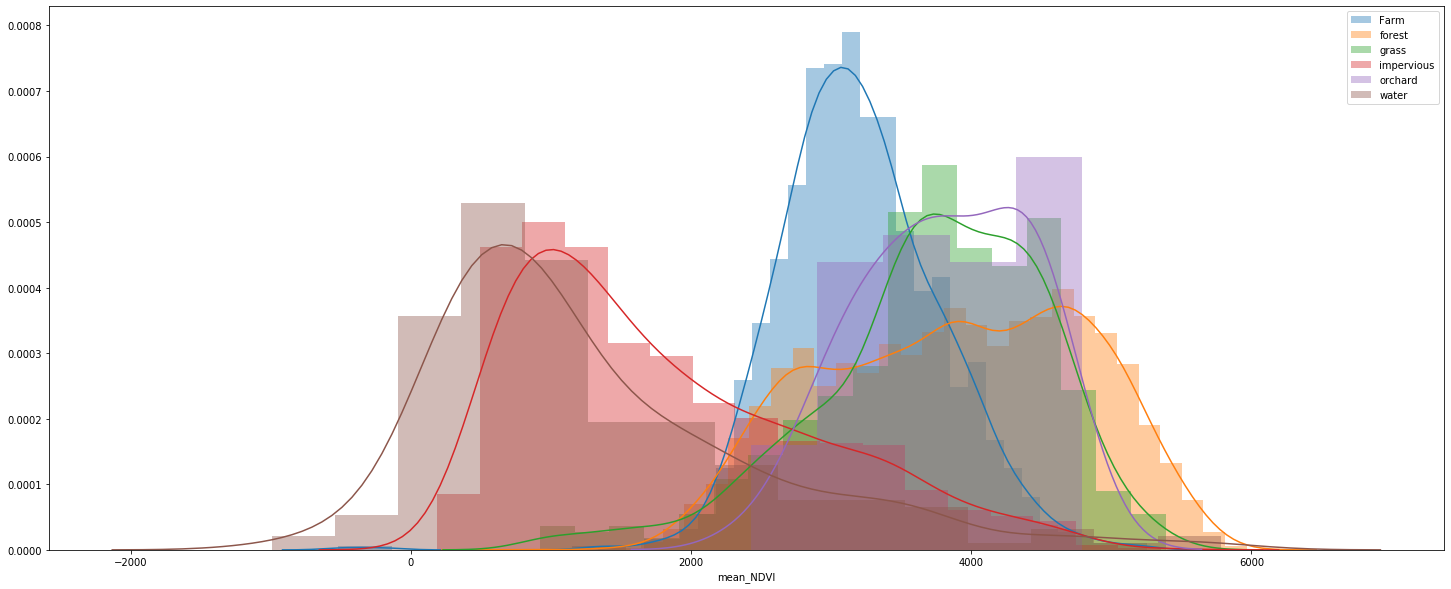

In [11]:
plt.figure(figsize=(25,10))
class_ndvi = train[train['class'] == 0]
sns.distplot(class_ndvi['mean_NDVI'], label='Farm')
class_ndvi = train[train['class'] == 1]
sns.distplot(class_ndvi['mean_NDVI'],  label='forest')
class_ndvi = train[train['class'] == 2]
sns.distplot(class_ndvi['mean_NDVI'], label='grass')
class_ndvi = train[train['class'] == 3]
sns.distplot(class_ndvi['mean_NDVI'], label='impervious')
class_ndvi = train[train['class'] == 4]
sns.distplot(class_ndvi['mean_NDVI'], label='orchard')
class_ndvi = train[train['class'] == 5]
sns.distplot(class_ndvi['mean_NDVI'], label='water')
plt.legend();

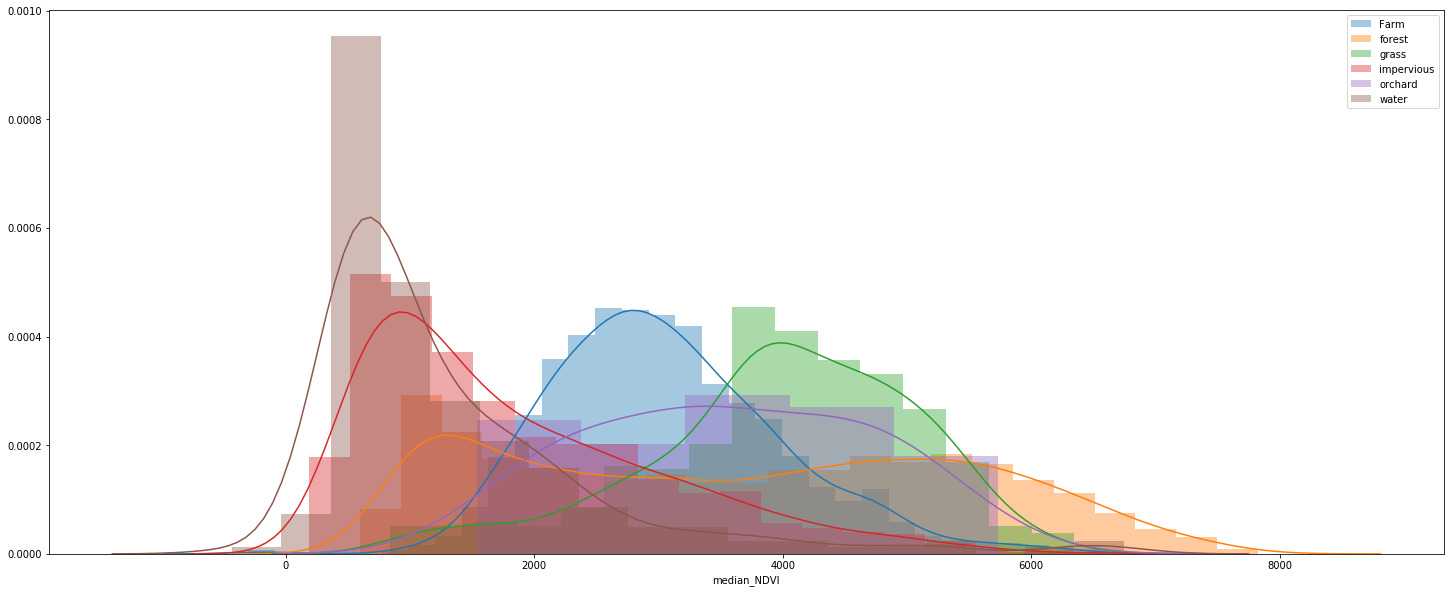

In [12]:
plt.figure(figsize=(25,10))
class_ndvi = train[train['class'] == 0]
sns.distplot(class_ndvi['median_NDVI'], label='Farm')
class_ndvi = train[train['class'] == 1]
sns.distplot(class_ndvi['median_NDVI'],  label='forest')
class_ndvi = train[train['class'] == 2]
sns.distplot(class_ndvi['median_NDVI'], label='grass')
class_ndvi = train[train['class'] == 3]
sns.distplot(class_ndvi['median_NDVI'], label='impervious')
class_ndvi = train[train['class'] == 4]
sns.distplot(class_ndvi['median_NDVI'], label='orchard')
class_ndvi = train[train['class'] == 5]
sns.distplot(class_ndvi['median_NDVI'], label='water')
plt.legend();

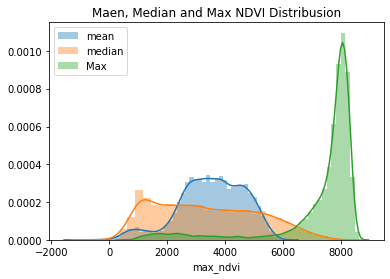

In [13]:
sns.distplot(train['mean_NDVI'], label='mean')
sns.distplot(train['median_NDVI'], label='median')
sns.distplot(train['max_ndvi'], label='Max')
plt.title('Maen, Median and Max NDVI Distribusion')
plt.legend();

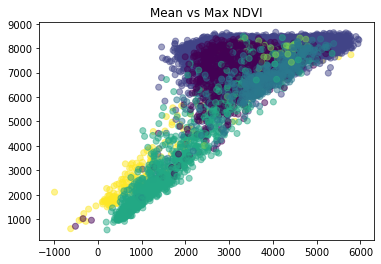

In [14]:
plt.scatter(train['mean_NDVI'], train['max_ndvi'], c=train['class'], alpha=.5);
plt.title("Mean vs Max NDVI");

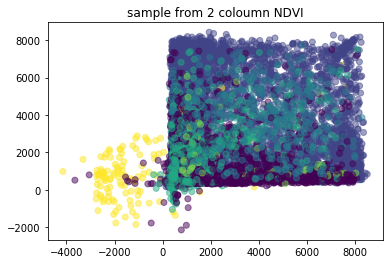

In [15]:
plt.scatter(train['20140101_N'], train['20140117_N'], c=train['class'], alpha=0.5);
plt.title('sample from 2 coloumn NDVI');

# Preprocessing

In [16]:
# split and scaling the data
X_train, X_val, y_train, y_val = train_test_split(train.iloc[:, 1:], train['class'], stratify=train['class'], test_size=.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scal = scaler.transform(X_val)

In [17]:
def model_valid_score(model, X_train, y_train):
    model.fit(X_train, y_train)
    print(classification_report(y_train, model.predict(X_train)))
    plot_confusion_matrix(model, X_train, y_train)
    print("General accuration Score: ",accuracy_score(y_train, model.predict(X_train)))

# Feature engineering and selection

## ANOVA

X selected:  (8436, 21)
X shape:  (8436, 30)

[ True  True  True  True  True False  True  True  True  True  True False
 False False  True False False  True  True  True False  True False  True
  True  True  True False  True  True]


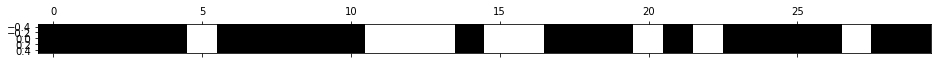

In [18]:
select = SelectPercentile(percentile=70) # keep 70% of the features
select.fit(X_train_scaled, y_train)
X_selected = select.transform(X_train_scaled)
print("X selected: ", X_selected.shape)
print("X shape: ", X_train.shape)
print()

mask = select.get_support()
# feature = list(zip(train.iloc[:,1:].columns, mask))
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r');

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1153
           1       0.97      0.99      0.98      5945
           2       0.87      0.81      0.84       357
           3       0.89      0.87      0.88       775
           4       1.00      0.29      0.44        42
           5       0.97      0.80      0.88       164

    accuracy                           0.95      8436
   macro avg       0.93      0.77      0.82      8436
weighted avg       0.95      0.95      0.95      8436

General accuration Score:  0.9484352773826458


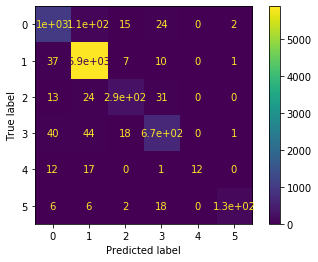

In [19]:
# with selected feature
model_valid_score(SVC(), X_selected, y_train)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1153
           1       0.98      0.99      0.99      5945
           2       0.96      0.85      0.90       357
           3       0.91      0.93      0.92       775
           4       1.00      0.57      0.73        42
           5       0.99      0.84      0.91       164

    accuracy                           0.97      8436
   macro avg       0.96      0.85      0.89      8436
weighted avg       0.97      0.97      0.97      8436

General accuration Score:  0.9672830725462305


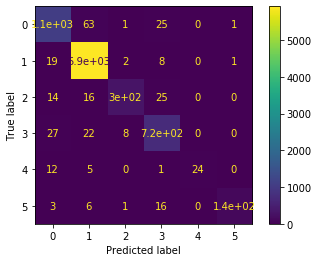

In [20]:
# without selected feature
model_valid_score(SVC(), X_train_scaled, y_train)

## Model Based Selection

[ True  True  True  True  True False  True False False False  True False
 False False  True  True  True  True  True False False  True False False
 False  True False False False  True]


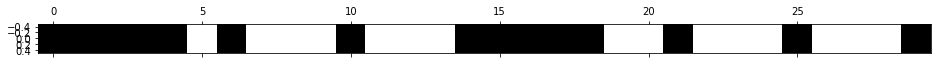

In [21]:
select_m = SelectFromModel(RandomForestClassifier(n_estimators=300), threshold='median')
select_m.fit(X_train_scaled, y_train)
X_select_model = select_m.transform(X_train_scaled)

mask = select_m.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [22]:
X_select_model.shape

(8436, 15)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1153
           1       0.96      0.99      0.98      5945
           2       0.89      0.76      0.82       357
           3       0.88      0.88      0.88       775
           4       1.00      0.10      0.17        42
           5       0.96      0.79      0.87       164

    accuracy                           0.94      8436
   macro avg       0.93      0.73      0.77      8436
weighted avg       0.94      0.94      0.94      8436

General accuration Score:  0.9449976292081556


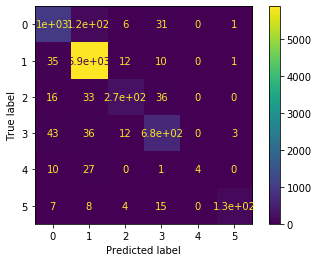

In [23]:
model_valid_score(SVC(), X_select_model, y_train)

## Recursive Feature Elimination (RFE)

[ True  True  True  True  True False False False False False  True False
 False False  True  True  True  True  True False False  True False False
 False  True False  True False  True]


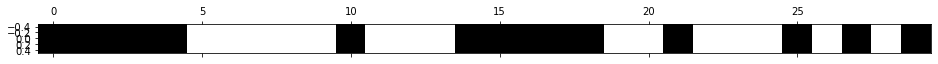

In [24]:
select_rfe = RFE(RandomForestClassifier(n_estimators=50), n_features_to_select=15)
select_rfe.fit(X_train_scaled, y_train)
X_select_RFE = select_rfe.transform(X_train_scaled)

mask = select_rfe.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1153
           1       0.96      0.99      0.98      5945
           2       0.94      0.79      0.86       357
           3       0.89      0.88      0.88       775
           4       1.00      0.19      0.32        42
           5       0.98      0.79      0.87       164

    accuracy                           0.95      8436
   macro avg       0.94      0.75      0.80      8436
weighted avg       0.95      0.95      0.94      8436

General accuration Score:  0.9467757230915126


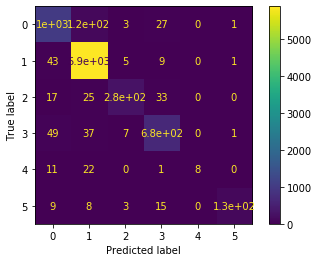

In [25]:
model_valid_score(SVC(), X_select_RFE, y_train)

without feature elimination accruray score slightly better, so I don't eliminate the feature

# Model Building and Selection

In [26]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

k_fold = KFold(n_splits=6)
def model_selection(model, X_train, y_train):
    model.fit(X_train, y_train)
    cros_val = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='accuracy')
    return np.mean(cros_val)

In [27]:
mods = {"knn": KNeighborsClassifier(n_neighbors=10), "SVC": SVC(kernel='rbf'), "RFC": RandomForestClassifier(), "GBC":GradientBoostingClassifier(n_estimators=50)}

score = {}
for key, val in mods.items():
    score[key] = model_selection(val, X_train_scaled, y_train)
score

{'knn': 0.956733048838312,
 'SVC': 0.9534139402560454,
 'RFC': 0.9387150308202941,
 'GBC': 0.9298245614035087}

## Pipeline and GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), SVC())
param = {"svc__C": [ 1, 3, 5, 6, 7, 20, 100],}
grid = GridSearchCV(pipe, param, scoring="accuracy", n_jobs=-1, cv=k_fold)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=6, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None

In [45]:
print("Score: ", grid.best_score_,"\nBest estimator: ", grid.best_estimator_)

Score:  0.9653864390706496 
Best estimator:  Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=6, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


In [46]:
grid.best_params_

{'svc__C': 6}

In [47]:
pipe = make_pipeline(StandardScaler(), SVC(C=6))
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=6, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [48]:
pipe.score(X_val, y_val)

0.9724988146040777

## Applying model to test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       300 non-null    object 
 1   max_ndvi    300 non-null    float64
 2   20150720_N  300 non-null    float64
 3   20150602_N  300 non-null    float64
 4   20150517_N  300 non-null    float64
 5   20150501_N  300 non-null    float64
 6   20150415_N  300 non-null    float64
 7   20150330_N  300 non-null    float64
 8   20150314_N  300 non-null    float64
 9   20150226_N  300 non-null    float64
 10  20150210_N  300 non-null    float64
 11  20150125_N  300 non-null    float64
 12  20150109_N  300 non-null    float64
 13  20141117_N  300 non-null    float64
 14  20141101_N  300 non-null    float64
 15  20141016_N  300 non-null    float64
 16  20140930_N  300 non-null    float64
 17  20140813_N  300 non-null    float64
 18  20140626_N  300 non-null    float64
 19  20140610_N  300 non-null    f

In [34]:
#feature adding
median = test.iloc[:,2:].median(axis=1)
mean = test.iloc[:,2:].mean(axis=1)
test['median_NDVI'] = median
test['mean_NDVI'] = mean
test.head()

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N,median_NDVI,mean_NDVI
0,water,2750.11,1361.89,-247.508,-521.17300,-1123.910,2653.08,-264.4140,-456.4660,2080.85,...,1778.030,2673.610,-178.9710,2238.580,1000.760,-81.5418,1146.260,-1566.490,1000.760,678.172526
1,water,2646.25,1760.85,481.100,6.26571,398.950,2646.25,550.9820,92.6923,2188.03,...,2029.520,1033.900,-19.6148,2183.660,927.882,668.7500,1519.740,-568.973,927.882,1016.958860
2,water,3509.62,3509.62,-241.320,-1239.32000,-330.388,1257.19,-175.1710,-294.5000,-1315.06,...,846.783,965.654,-468.0240,-222.312,1124.250,1132.9000,594.059,-993.658,846.783,722.334296
3,water,2820.47,2138.69,-126.186,-522.28100,-741.163,2334.70,-207.4360,-76.9686,2820.47,...,2239.330,593.874,1540.8800,2398.420,846.470,572.3080,1311.610,-1396.500,867.671,848.655793
4,water,2684.13,1995.80,-1029.570,1713.62000,-472.258,2526.99,-91.7429,-146.2260,2487.71,...,2174.890,1321.690,1351.5800,2381.950,870.890,1174.3300,991.427,-185.322,1303.080,1162.717930


In [35]:
test['class'] = encoder.transform(test['class'])

In [36]:
test.tail(2)

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N,median_NDVI,mean_NDVI
298,5,973.953,-3004.63,-1217.12,180.122,-1113.89,438.418,-2442.51,-3210.56,-3237.74000,...,-3472.65,-3109.07,511.792,369.097,276.948,-5574.51,298.739,460.419,-317.092,-1170.447741
299,5,516.427,-2975.10,-1129.79,463.748,-5355.40,193.511,-2590.16,-3113.52,-2.38883,...,-3335.00,-2929.19,-1007.500,271.058,307.997,-5453.33,307.495,417.124,-791.937,-1433.671386


In [43]:
#Split data and label
X, y = test.iloc[:,1:], test['class']
pipe.score(X, y)

0.59

# Conclution

from this I got only 59% accuracy with my model with from unseen data, from data description training data has label error from labelling process. it's hard since we don't know which one in incorrect